## 1. 背景

上海二月起更新以下限购政策
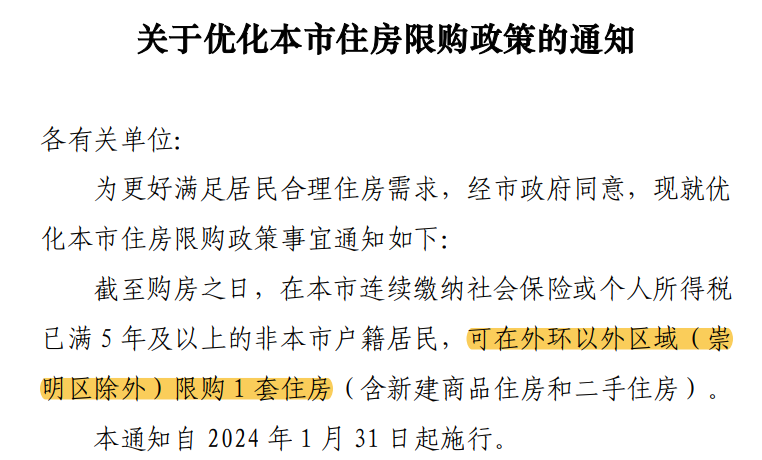
结合市场情况可知，限购政策发布后，2024年3月，各环线基价均值仍维持微弱下降趋势，随区域之间的差异略有缩小，但同比跌幅进一步扩大。


## 2. 数据收集与描述

我们考虑到政策时间选取1月和4月数据进行研究。选取房屋均价作为因变量，城镇化率、人均GDP、人口密度等关键指标作为因变量，同时构建限购政策的Treatment Effect变量进行OLS回归。

首先，我们进行描述性统计。总的来看，房价分布及其变化如柱状和散点图所示：

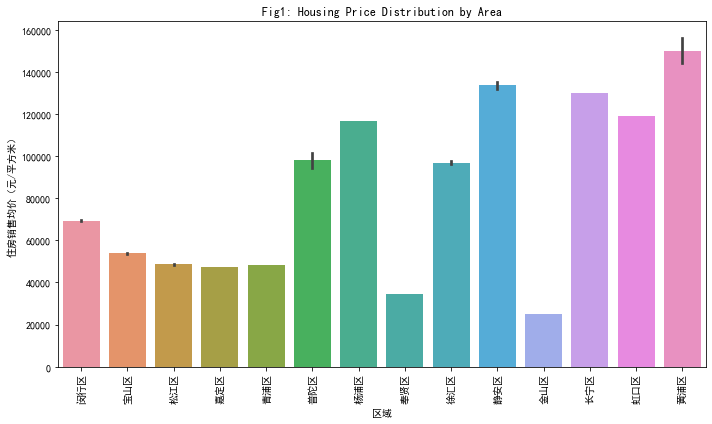

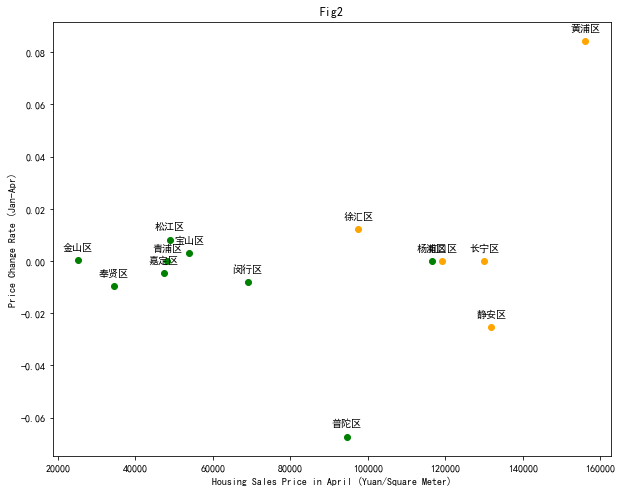

In [31]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

df_m1 = pd.read_excel('E:\\jupyter\\House_m1.xlsx')
df_m4 = pd.read_excel('E:\\jupyter\\House_m4.xlsx')

# 合并数据集
df = pd.concat([df_m1, df_m4], ignore_index=True)

# 去除百分号并将列转换为字符串类型
df['城镇化率'] = df['城镇化率'].astype(str).str.rstrip('%')
df_m1['城镇化率'] = df_m1['城镇化率'].astype(str).str.rstrip('%')
df_m4['城镇化率'] = df_m4['城镇化率'].astype(str).str.rstrip('%')

# 将百分比转换为小数
df['城镇化率'] = df['城镇化率'].astype('float') / 100.0
df_m1['城镇化率'] = df_m1['城镇化率'].astype('float') / 100.0
df_m4['城镇化率'] = df_m4['城镇化率'].astype('float') / 100.0


# 1. 房价分布图
plt.figure(figsize=(10, 6))
sns.barplot(x='区域', y='住房销售均价（元/平方米）', data=df)
plt.title('Fig1: Housing Price Distribution by Area')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#2.散点图
# 定义限购区域（内环）和非限购区域（外环）的列表
restricted_areas = ['闵行区', '宝山区', '松江区', '嘉定区', '青浦区', '普陀区', '杨浦区', '奉贤区', '金山区']
non_restricted_areas = ['徐汇区', '静安区', '长宁区', '虹口区', '黄浦区']

# 初始化图形
plt.figure(figsize=(10, 8))

# 绘制限购区域的散点图，并添加注释
for area in restricted_areas:
    # 找到对应区域的数据
    m1_price = df_m1[df_m1['区域'] == area]['住房销售均价（元/平方米）'].values[0]
    m4_price = df_m4[df_m4['区域'] == area]['住房销售均价（元/平方米）'].values[0]
    change_rate = (m4_price - m1_price) / m1_price
    
    # 绘制散点并添加注释
    plt.scatter(m4_price, change_rate, color='green', label=f'{area} (Restricted)')
    plt.annotate(f'{area}', (m4_price, change_rate), textcoords="offset points", xytext=(0,10), ha='center')

# 绘制非限购区域的散点图，并添加注释
for area in non_restricted_areas:
    # 找到对应区域的数据
    m1_price = df_m1[df_m1['区域'] == area]['住房销售均价（元/平方米）'].values[0]
    m4_price = df_m4[df_m4['区域'] == area]['住房销售均价（元/平方米）'].values[0]
    change_rate = (m4_price - m1_price) / m1_price
    
    # 绘制散点并添加注释
    plt.scatter(m4_price, change_rate, color='orange', label=f'{area} (Non-Restricted)')
    plt.annotate(f'{area}', (m4_price, change_rate), textcoords="offset points", xytext=(0,10), ha='center')

# # 设置图例
# plt.legend(loc='upper right', fontsize=10)

# 设置标题和坐标轴标签
plt.title('Fig2')
plt.xlabel('Housing Sales Price in April (Yuan/Square Meter)')
plt.ylabel('Price Change Rate (Jan-Apr)')

# 显示图表
plt.show()

## 3. OLS回归



OLS数学模型：

$$y_i = \beta_1 \cdot urbanization\_rate_i + \beta_2 \cdot per\_capita\_GDP_i + \beta_3 \cdot population\_density_i + \beta_4 \cdot TreatmentEffect_i + \epsilon_i$$

在这个模型中，我们假设误差项 $\epsilon_i$ 是独立同分布的，并且服从均值为0的正态分布。OLS估计的目标是最小化残差平方和，即最小化：

$$\sum_{i=1}^{n} \epsilon_i^2 = \sum_{i=1}^{n} (y_i - \beta_1 \cdot urbanization\_rate_i - \beta_2 \cdot per\_capita\_GDP_i - \beta_3 \cdot population\_density_i - \beta_4 \cdot TreatmentEffect_i)^2$$

通过对残差平方和进行最小化，可以得到回归系数 $\beta$ 的估计值。

In [32]:

# 合并数据集，以区域和时间为索引
df_m1['Time'] = 'm1'
df_m4['Time'] = 'm4'
df = pd.concat([df_m1, df_m4])

# 添加区域虚拟变量
df['Region'] = df.apply(lambda x: 1 if x['区域'] in ['闵行区', '宝山区', '松江区', '嘉定区', '青浦区', '普陀区', '杨浦区', '奉贤区', '金山区'] else 0, axis=1)

# 添加时间虚拟变量
df['Time'] = df.apply(lambda x: 1 if x['Time'] == 'm4' else 0, axis=1)

# 定义处理组和对照组
df['Treatment'] = (df['Region'] == 1) & (df['Time'] == 1)

# 构建交互变量
df['TreatmentEffect'] = df['Treatment'] * df['Time']

# 构建回归模型的自变量
X = df[[ '城镇化率', '人均GDP（万元）', '人口密度（人/km²）', 'TreatmentEffect']]
y = df['住房销售均价（元/平方米）']

# 构建回归模型并拟合
model = sm.OLS(y, X).fit()

# 输出回归结果
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:          住房销售均价（元/平方米）   R-squared (uncentered):                   0.961
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                              148.7
Date:                Wed, 10 Apr 2024   Prob (F-statistic):                    1.45e-16
Time:                        10:29:30   Log-Likelihood:                         -314.50
No. Observations:                  28   AIC:                                      637.0
Df Residuals:                      24   BIC:                                      642.3
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

首先，我们观察回归结果的系数和统计量，并辅以python可视化说明：
1. 城镇化率（Fig3）：系数为7.532e+04，且t统计量的P值接近0，表明城镇化率对房价有显著的正向影响。随着城镇化率的提高，住房需求增加，从而推高了房价。
2. 人均GDP（Fig4）：系数为1681.2984，t统计量的P值也接近0，说明人均GDP的提高同样对房价有显著的正向影响。人均GDP的增加反映了居民收入水平的提高，增加了购房能力，从而可能推高房价。
3. 人口密度（Fig5）：系数为-96.9555，但t统计量的P值为0.081，略高于常用的显著性水平0.05，表明人口密度对房价的影响不是非常显著。
4. TreatmentEffect（处理效应）：系数为-1.244e+04，t统计量的P值为0.150，远高于0.05的显著性水平，这意味着限购政策的实施对房价的影响在统计上并不显著。说明市场转折点暂未到来(Fig6)，政策效益传导到市场需要一定时间，整体市场还需要经历一段时间的“弱复苏”阶段。

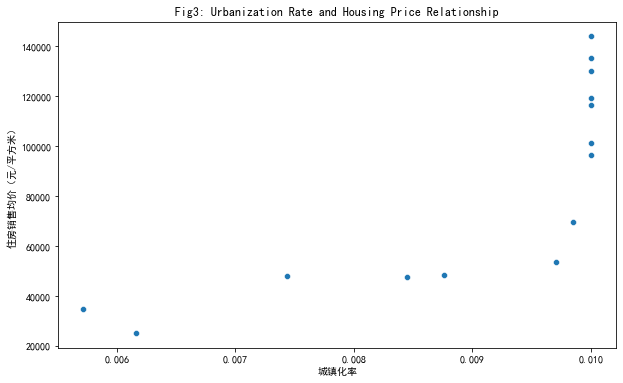

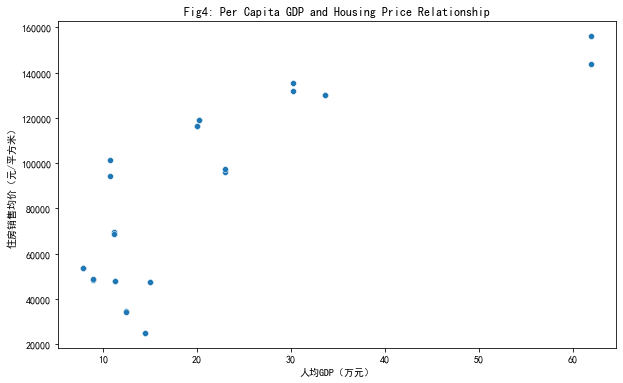

D:\anaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


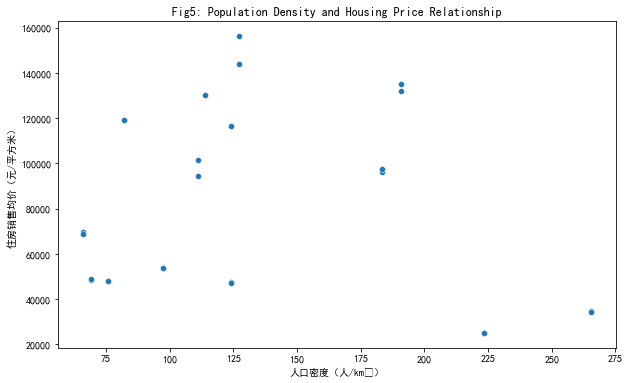

In [33]:


# 2. 城镇化率与房价关系图
plt.figure(figsize=(10, 6))
sns.scatterplot(x='城镇化率', y='住房销售均价（元/平方米）', data=df_m1 if df_m1['城镇化率'].mean() < 0.5 else df_m4)
plt.title('Fig3: Urbanization Rate and Housing Price Relationship')
plt.show()

# 3. 人均GDP与房价关系图
plt.figure(figsize=(10, 6))
sns.scatterplot(x='人均GDP（万元）', y='住房销售均价（元/平方米）', data=df)
plt.title('Fig4: Per Capita GDP and Housing Price Relationship')
plt.show()

# 4. 人口密度与房价关系图
plt.figure(figsize=(10, 6))
sns.scatterplot(x='人口密度（人/km²）', y='住房销售均价（元/平方米）', data=df)
plt.title('Fig5: Population Density and Housing Price Relationship')
plt.show()




## 4.基本假设检验

Jarque-Bera Test Statistic: 2.12
p-value: 0.35

Durbin-Watson statistic: 1.791338580745965


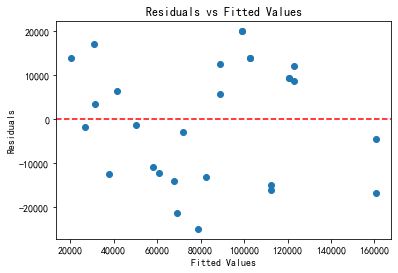

Variance Inflation Factor (VIF):
      Variable         VIF
0        const  124.526382
1         城镇化率    2.242944
2    人均GDP（万元）    1.397238
3  人口密度（人/km²）    1.788592
4         是否限购    1.322260


In [45]:
import statsmodels.api as sm
import statsmodels.stats.stattools as st


# 合并数据集
df = pd.concat([df_m1, df_m4])

# 将百分比转换为小数
df['城镇化率'] = df['城镇化率'].astype(str).str.rstrip('%').astype('float') / 100.0
df['是否限购'] = df['是否限购（0是1否）'].astype(int)

# 定义自变量和因变量
X = df[['城镇化率', '人均GDP（万元）', '人口密度（人/km²）', '是否限购']]
y = df['住房销售均价（元/平方米）']

# 添加常数项以便拟合截距
X = sm.add_constant(X)

# 构建并拟合OLS模型
model = sm.OLS(y, X).fit()

# 输出回归结果摘要
# print(model.summary())

# 检验残差的正态性 - Jarque-Bera检验
# 获取模型残差
residuals = model.resid

# 计算Jarque-Bera检验的结果
jarque_bera_test = sm.stats.jarque_bera(residuals)

# 输出Jarque-Bera检验结果
print("Jarque-Bera Test Statistic: {:.2f}".format(jarque_bera_test[0]))
print("p-value: {:.2f}\n".format(jarque_bera_test[1]))

# 检验残差的独立性 - Durbin-Watson检验
durbin_watson_statistic = st.durbin_watson(residuals)
print("Durbin-Watson statistic:", durbin_watson_statistic)


# 检验同方差性 - 残差图
residuals = model.resid
plt.scatter(model.fittedvalues, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# 检验多重共线性 - 方差膨胀因子（VIF）
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("Variance Inflation Factor (VIF):")
print(vif)



1. **Jarque-Bera Test**:
   - 检验统计量为2.12，p值为0.35。这个p值相对较高，远高于常用的显著性水平（例如0.05），这意味着我们没有足够的证据拒绝正态性的原假设。换句话说，根据Jarque-Bera检验，模型残差近似正态分布，满足OLS回归的正态性假设。

2. **Durbin-Watson Test**:
   - 检验统计量为1.791，这个值接近于2，表明残差之间没有显著的一阶自相关性。一般来说，杜宾-沃森统计量的值在1.5到2.5之间被认为是可以接受的，表明残差之间没有严重的自相关问题。因此，根据Durbin-Watson检验，我们可以认为模型残差满足独立性假设。

3. **残差图**:
    - 残差的散布在整个拟合值的范围内保持相对恒定，不随着拟合值的增加而变宽或变窄。这意味着残差的方差是恒定的，满足同方差性假设。

4. **Variance Inflation Factor (VIF, 方差膨胀因子)**:
   - 所有变量的VIF值都远低于10，这表明模型中不存在严重的多重共线性问题。特别是，"const"（常数项）的VIF值非常高，但这并不影响模型的解释，因为常数项的作用是捕捉截距的变化，而不是解释因变量的变化。
   - "城镇化率"的VIF值为2.242944，虽然略高于其他变量，但仍在可接受范围内。这意味着"城镇化率"与模型中其他变量之间不存在强烈的线性关系，不会对模型的稳定性造成影响。


## 5. 讨论

宏观来看，降息、降首付叠加特定区域限购放松，使得上海外围区域关注度提升，尤其是规划和配套设施等相对完善且总价具有优势的刚需市场或率先回暖。

然而，基于OLS回归结果，可能由于近五年土地经济模式受到的持续冲击，**市场转折点暂未到来(Fig6)**，政策效益传导到市场需要一定时间，存量住宅市场仍然普遍存在“以价换量”的情况。部分区域出现“小阳春”，如黄埔、徐汇、松江区，但整体市场还需要经历一段时间的“弱复苏”阶段。|



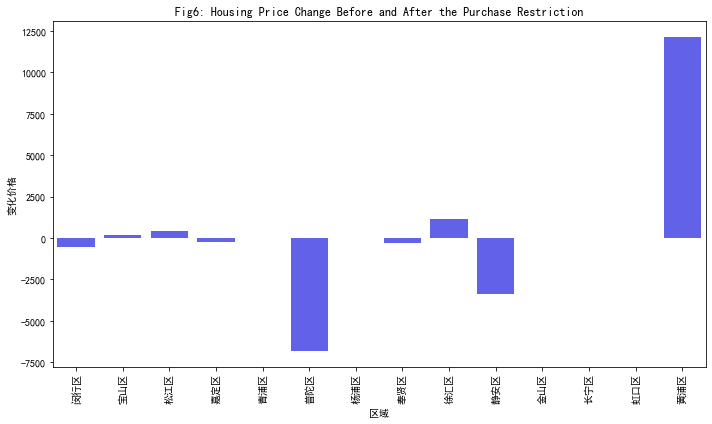

In [28]:

# 将变化价格 change_price 转换为 DataFrame
change_price_df = pd.DataFrame({'区域': df_m1['区域'], '变化价格': change_price})

# 绘制柱状图
plt.figure(figsize=(10, 6))
sns.barplot(x='区域', y='变化价格', data=change_price_df, color='blue', alpha=0.7)
plt.title('Fig6: Housing Price Change Before and After the Purchase Restriction')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()